In [46]:
import sys
sys.path.append('../bayesopt')

import read_agg_data
import torch
import torch.nn as nn
import torch.autograd as auto
import torch.optim as optim

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

import pdb
import math

dvfs_dict = {
    "0xc00" :  1.2,
    "0xd00" :  1.3,
    "0xe00" :  1.4,
    "0xf00" :  1.5,
    "0x1000" : 1.6,
    "0x1100" : 1.7,
    "0x1200" : 1.8,
    "0x1300" : 1.9,
    "0x1400" : 2.0,
    "0x1500" : 2.1,
    "0x1600" : 2.2,
    "0x1700" : 2.3,
    "0x1800" : 2.4,
    "0x1900" : 2.5,
    "0x1a00" : 2.6,
    "0x1b00" : 2.7,
    "0x1c00" : 2.8,
    "0x1d00" : 2.9,
    "0xffff" : 3.0,
}

In [47]:
#df_comb, _, _ = read_agg_data.start_analysis('mcd') #DATA
#df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: int(x, base=16))

df_comb = pd.read_csv('/home/handong/jupyter/jupyter-notebooks/nic-tuning-experiments/bayesopt/summary_data/netpipe_combined.csv', sep=' ')
df_comb = df_comb[(df_comb['i'] == 1) & (df_comb['rapl'] == 135)]
#df_comb = df_comb[(df_comb['rapl'] == 135)]

df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: dvfs_dict[x])
df_comb = df_comb[(df_comb['itr']!=1) & (df_comb['dvfs']!=65535)] #filter out linux dynamic

print(df_comb['time'].min())
print(df_comb.columns)
print(df_comb['itr'].unique())
print(df_comb['dvfs'].unique())
print(df_comb['msg'].unique())
print(df_comb['sys'].unique())
print(df_comb.shape[0])

# df_comb['dvfs'] = df_comb['dvfs'].astype(float) / df_comb['dvfs'].min()
# print(df_comb['dvfs'].unique())
# df_comb['itr'] = df_comb['itr'].astype(float) / df_comb['itr'].min()
# print(df_comb['itr'].unique())
#print(10**6)

0.11199999999999999
Index(['sys', 'i', 'msg', 'itr', 'dvfs', 'rapl', 'time', 'tput', 'joules',
       'rx_bytes', 'tx_bytes', 'instructions', 'cycles', 'ref_cycles',
       'llc_miss', 'c1', 'c1e', 'c3', 'c6', 'c7', 'num_interrupts'],
      dtype='object')
[ 6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40  2  4]
[1.2 1.5 1.6 1.7 1.8 2.  2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 1.3 1.9 2.1]
[  8192  65536 524288     64]
['ebbrt_tuned' 'linux_tuned']
1259


In [161]:
#6  8 10 12 16 20 24 28
for itr in [6, 8, 10, 12, 16, 20, 24, 28]:
    for sys in ['ebbrt_tuned']:
        for msg in [8192]:
            df = df_comb[(df_comb['sys']==sys) & (df_comb['msg'] == msg)].copy()
            #print(df.shape[0])
            print(df['joules'].max())
            #df['joules_per_interrupt'] = df['joules']/df['num_interrupts']
            df = df[['joules','itr', 'dvfs', 'time', 'num_interrupts']]
            #print(df.shape[0])
            #print('')
            
            dfi = df[df['itr']==itr]
            #dfi = dfi.drop_duplicates(subset = ["itr", "dvfs"])
            #dfi['joules_mean'] = dfi['joules_mean']/dfi['joules_mean'].max()
            #print(dfi.diff())
            print('*******', sys, itr, msg)
            print(dfi.sort_values(by=['dvfs']))
            #print(dfi.sort_values(by=['dvfs']).diff())
            print('')
            #plt.plot(dfi['dvfs'], dfi['joules_per_interrupt'])
            #print(dfi)

7.5
******* ebbrt_tuned 6 8192
     joules  itr  dvfs   time  num_interrupts
1      4.36    6   1.2  0.234           19979
143    4.88    6   1.5  0.244           21176
325    4.76    6   1.7  0.220           17655
391    5.36    6   1.8  0.243           20307
468    4.68    6   2.2  0.217           25768
501    4.79    6   2.3  0.218           25520
528    4.84    6   2.4  0.218           25491
561    4.85    6   2.5  0.217           25406
588    4.95    6   2.6  0.218           25589
647    5.24    6   2.9  0.221           25753

7.5
******* ebbrt_tuned 8 8192
     joules  itr  dvfs   time  num_interrupts
12     5.54    8   1.2  0.297           20094
154    5.55    8   1.5  0.278           17962
334    5.61    8   1.7  0.259           18201
400    6.10    8   1.8  0.279           19294
474    4.99    8   2.2  0.240           21966
504    5.05    8   2.3  0.238           21867
534    4.92    8   2.4  0.230           20924
564    5.05    8   2.5  0.232           21062
594    5.10    8 

In [10]:
print(8192*8/(10**10))

6.5536e-06


In [218]:
def inference(d, n_iter, lr, workload, sys, print_freq=10):
    # p_busy_min = 20
    p_static = {
        'c1':1.5, 
        'c3':0.5,
        'c4':0.25,
        'c7':34, # 34 Watts
        'busy': 10
    }
    chosen_sleep = 'c7'

    p_q = p_static[chosen_sleep]/10**6 # joules/us idle
    # p_detect = p_static[chosen_sleep]

    #<ipython-input-38-bca31b34de20>:16: UserWarning: To copy construct from a tensor, 
    # it is recommended to use sourceTensor.clone().detach() 
    # or sourceTensor.clone().detach().requires_grad_(True), 
    # rather than torch.tensor(sourceTensor).
    
    #starts randomly
    max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
    alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
    beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
    gamma = torch.tensor(torch.Tensor(1,1).uniform_(0, 0.2), requires_grad=True)
    delta = torch.tensor(torch.Tensor(1,1).uniform_(0.6, 0.7), requires_grad=True)
    eta = torch.tensor(torch.Tensor(1,1).uniform_(3, 3), requires_grad=True)
    #beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2)).clone().detach()
    #p_static_busy = torch.tensor(torch.Tensor(1,1).uniform_(0, 35)).clone().detach()
    #p_detect = torch.tensor(torch.Tensor(1,1).uniform_(0, 35)).clone().detach()
    #p_q = torch.tensor(torch.Tensor(1,1).uniform_(0, 35), requires_grad=True)
    #p_busy_min = torch.tensor(torch.Tensor(1,1).uniform_(0, 35)).clone().detach()
    #itr_suppress = torch.rand(1, requires_grad=True)
    #itr_suppress = torch.tensor(1., requires_grad=True)
    
    AA = torch.tensor(torch.Tensor(1,1).uniform_(20, 21), requires_grad=True)
    BB = torch.tensor(torch.Tensor(1,1).uniform_(2, 3), requires_grad=True)
    CC = torch.tensor(torch.Tensor(1,1).uniform_(12, 14), requires_grad=True)
    #gamma = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1)).clone().detach()
    
    #df[['joules_mean','itr', 'dvfs', 'QPS', 'read_99th_mean']]
    #df[['joules', 'itr', 'dvfs', 'time', 'num_interrupts']]
    ninterrupts = d[:,4]
    energy = (d[:,0]/5000) ## joules/num_interrupts
    itr = d[:,1]
    dvfs = d[:,2]
    time = (d[:,3]/5000)
    msgsize = d[:,5]
    
    current_loss_time = -100
    fixed_max_time = -100
    fixed_alpha = -100
    fixed_beta = -100
    fixed_gamma = -100
    
    criterion = nn.MSELoss()
    #optimizer_time = optim.Adam([max_time, alpha, gamma, delta], lr=lr)
    optimizer_time = optim.Adam([max_time, alpha, beta, gamma], lr=lr)
    optimizer_energy = optim.Adam([AA, BB, CC, eta], lr=lr)

    for i in range(n_iter):        
        t_busy = (torch.exp(max_time) / dvfs**(1+alpha)) ## dvfs impact on processing
        
        #pred_time = itr_suppress*itr + t_busy
        #pred_time = ((2*((itr*itr_suppress)**beta))/(10**6)) + (gamma*(2*((msgsize*8)/(10**10)))) + (2*t_busy)
        #pred_time = (gamma*itr*itr_suppress)*(dvfs**beta)
        #pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy)                
        
        #pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy) + (2*((msgsize*8)/(10**10)))
        beta = gamma*dvfs+delta
        pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy) + (2*((msgsize*8)/(10**10)))
        
        #pred_time = A(itr)**beta*(dvfs**gamma)
        #pred_time = 2*itr**(alpha*dvfs)
        
        #import pdb
        #pdb.set_trace()
        
        #loss_time = criterion(pred_time/time, torch.ones((1,pred_time.shape[1])).double())
        loss_time = criterion(pred_time, time)
        
        if i % 1000 == 0:
            print(f'MSE_loss_time={loss_time.item()} loss_time={round(math.sqrt(loss_time.item())*10**6, 5)} us '
                 + f'max_time={max_time.item()} alpha={alpha.item()} gamma={gamma.item()} delta={delta.item()} ')
            
        optimizer_time.zero_grad()
        loss_time.backward()
        optimizer_time.step()
                        
        if(current_loss_time == -100):
            current_loss_time = loss_time.item()
        else:
            if(current_loss_time >= loss_time.item()):
                current_loss_time = loss_time.item()

    alpha.requires_grad = False
    gamma.requires_grad = False
    delta.requires_grad = False
    max_time.requires_grad = False

#                 fixed_max_time = max_time.item()
#                 fixed_alpha = alpha.item()
#                 fixed_delta = delta.item()
#                 fixed_gamma = gamma.item()
            
    for i in range(n_iter):
        #fixed_t_busy = (torch.exp(fixed_max_time) / dvfs**(1+fixed_alpha)) ## dvfs impact on processing
        #fixed_beta = fixed_gamma*dvfs+fixed_delta
        #pred_energy = AA*((2*(((itr**fixed_beta))))/(10**6)) + BB*(2*fixed_t_busy) + CC*(2*((msgsize*8)/(10**10)))
        
        t_busy = (torch.exp(max_time) / dvfs**(1+alpha)) ## dvfs impact on processing
        beta = gamma*dvfs+delta
        pred_energy = AA*((2*(((itr**beta))))/(10**6)) + (BB*dvfs**eta+CC)*(2*t_busy) + AA*(2*((msgsize*8)/(10**10)))
        
        ## energy is function of power and work
        ## 
        
        #p_busy = (p_q*dvfs**(2+beta))
        #t_busy_energy = (max_time / dvfs**(1+beta))
        #t_q_energy = itr#(fixed_itr_suppress*itr)
        #t_q_energy = (interarrival_time - (fixed_itr_suppress*itr) - t_busy_energy)
        
        #pred_energy = (p_q * t_q_energy) + (p_busy * t_busy_energy)
        #pred_energy = AA*(fixed_itr_suppress*itr)**gamma + BB*dvfs**beta
        #loss_energy = criterion(pred_energy/energy, torch.ones((1,pred_energy.shape[1])).double())
        #pred_energy =  ((fixed_itr_suppress*itr*p_q)*((20*(10**6))/(fixed_itr_suppress*itr))) + (dvfs*beta)
        #pred_energy = (gamma*(fixed_itr_suppress*itr))*(dvfs**beta) #+ (AA*(dvfs**beta))
        
        #pred_energy = 2*(gamma+(np.log(itr)))+(2*(beta*np.log(dvfs)))
        
        #pred_energy = (*itr + t_busy_energy)*p_q
        loss_energy = criterion(pred_energy, energy)

        if i % 1000 == 0:
            print(f'MSE_loss_energy={loss_energy.item()} loss_energy={math.sqrt(loss_energy.item())}J AA={AA.item()} BB={BB.item()} CC={CC.item()} eta={eta.item()}')
            #print(pred_energy)
            
        optimizer_energy.zero_grad()
        loss_energy.backward(retain_graph=True)
        optimizer_energy.step()
    return pred_energy, pred_time

In [237]:
def run(df_comb, n_iter=2000, lr=1, rmsg=64, msys=['ebbrt_tuned'], mpred=['energy', 'time']):       
    df_comb = df_comb[df_comb['msg'] == rmsg]
    i=1
    
    for sys in msys:
        df = df_comb[(df_comb['sys']==sys)].copy()
        #df = df[['joules','itr', 'dvfs', 'QPS', 'read_99th', 'num_interrupts']]
        print(df['itr'].unique())
        df = df[['joules', 'itr', 'dvfs', 'time', 'num_interrupts', 'msg']]
        
        tnum = df.shape[0]
        d = df.values
        d = torch.tensor(d)
        print('SYS', sys)
        
        #pred_energy, max_time, alpha, beta, p_detect, p_q = inference_energy(d, n_iter, lr, 'mcd', sys, print_freq=1000)
        pred_energy, pred_time = inference(d, n_iter, lr, 'netpipe', sys, print_freq=1000)
        for pred_name in mpred:
            if pred_name == 'energy':
                #pred_energy = inference(d, n_iter, lr, 'netpipe', sys, print_freq=1000)
                pred = pred_energy
                #yvalue = (d[:,0]/d[:,4]).log()
                yvalue = (d[:,0]/5000)
                #yvalue = d[:,0]
            else:
                #pred_time = inference_time(d, n_iter, lr, 'netpipe', sys, print_freq=1000)
                pred = pred_time
                yvalue = d[:,3]/5000

            #fig, ax = plt.subplots()
            ax = plt.subplot(1, len(msys)*len(mpred), i)
            
            if sys == 'ebbrt_tuned':
                plt.title(f'EbbRT @ {rmsg} B', fontsize=18)
            else:
                plt.title(f'Linux @ {rmsg} B', fontsize=18)
                
            if pred_name == 'energy':
                plt.ylabel('Measured Energy (J)', fontsize=18)
                plt.xlabel('Pred. Energy (J)', fontsize=18)
            else:
                plt.ylabel('Measured Time (s)', fontsize=18)
                plt.xlabel('Pred. Time (s)', fontsize=18)
                            
            
            #if pred_name == 'time':
            tmax = yvalue.max().item()
            plt.plot(np.linspace(0, tmax, 10), np.linspace(0, tmax, 10))
            
            scatter = ax.scatter(pred.detach().numpy(), yvalue, marker = 'o', 
                                 s = d[:,1], c = d[:,2], alpha=0.5)
            #scatter = ax.scatter(pred.detach().numpy(), yvalue, marker = 'o', alpha=0.3)
            plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
            plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
                        
            legend1 = ax.legend(*scatter.legend_elements(),loc="upper left", title="dvfs")
            ax.add_artist(legend1)
            handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
            legend2 = plt.legend(handles, labels, loc="lower right", title="itr")
            ax.add_artist(legend2)
            
            plt.grid(True)
            plt.tight_layout()
            i += 1
    plt.subplots_adjust(wspace=0.3, hspace=0)

In [245]:
print(math.exp(-9.74), math.exp(-10.86), math.exp(-10.39), math.exp(-10.7))


5.888053484147942e-05 1.9211528815372642e-05 3.073833454742418e-05 2.254493791321221e-05


[ 6  8 10 12 14 16 20 24 28 30]
SYS ebbrt_tuned
MSE_loss_time=3.0218504222293235e-10 loss_time=17.38347 us max_time=-10.145421028137207 alpha=0.10499846935272217 gamma=0.10147801786661148 delta=0.6083422303199768 


<ipython-input-218-ecec3a150831>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-218-ecec3a150831>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:24: UserWarning: To copy cons

MSE_loss_time=5.340832578946276e-11 loss_time=7.3081 us max_time=-10.677175521850586 alpha=-0.21166090667247772 gamma=0.1268179714679718 delta=0.6083422303199768 
MSE_loss_time=4.376403461759977e-11 loss_time=6.61544 us max_time=-10.755624771118164 alpha=-0.5100135803222656 gamma=0.11052645742893219 delta=0.6083422303199768 
MSE_loss_time=3.912409090754213e-11 loss_time=6.25493 us max_time=-10.817151069641113 alpha=-0.7148424386978149 gamma=0.100267194211483 delta=0.6083422303199768 
MSE_loss_time=3.70452771260743e-11 loss_time=6.08648 us max_time=-10.862042427062988 alpha=-0.8507832884788513 gamma=0.09431173652410507 delta=0.6083422303199768 
MSE_loss_energy=1.2256786277872293e-07 loss_energy=0.0003500969334037688J AA=20.33348274230957 BB=2.751593589782715 CC=12.721452713012695 eta=3.0
MSE_loss_energy=1.0893079061410922e-08 loss_energy=0.00010436991454155226J AA=18.1312255859375 BB=3.0495898723602295 CC=12.076119422912598 eta=2.5464365482330322
MSE_loss_energy=1.0681075665653341e-08 l

<ipython-input-218-ecec3a150831>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-218-ecec3a150831>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:24: UserWarning: To copy cons

MSE_loss_time=4.355920927282618e-11 loss_time=6.59994 us max_time=-9.790987014770508 alpha=-0.3873150050640106 gamma=0.10078710317611694 delta=0.6915727257728577 
MSE_loss_time=4.062206576178975e-11 loss_time=6.37354 us max_time=-9.746745109558105 alpha=-0.25214552879333496 gamma=0.11091745644807816 delta=0.6915727257728577 
MSE_loss_time=4.0599879528252786e-11 loss_time=6.3718 us max_time=-9.74301528930664 alpha=-0.2403123825788498 gamma=0.11184757202863693 delta=0.6915727257728577 
MSE_loss_time=4.0599703090881e-11 loss_time=6.37179 us max_time=-9.742691993713379 alpha=-0.2392820566892624 gamma=0.11192911863327026 delta=0.6915727257728577 
MSE_loss_energy=2.121346262212193e-08 loss_energy=0.00014564842128262815J AA=20.979084014892578 BB=2.2917745113372803 CC=12.156291007995605 eta=3.0
MSE_loss_energy=1.726046689300761e-08 loss_energy=0.0001313790961036329J AA=18.13074493408203 BB=3.6570587158203125 CC=13.996180534362793 eta=2.4422571659088135
MSE_loss_energy=1.70306534511581e-08 loss

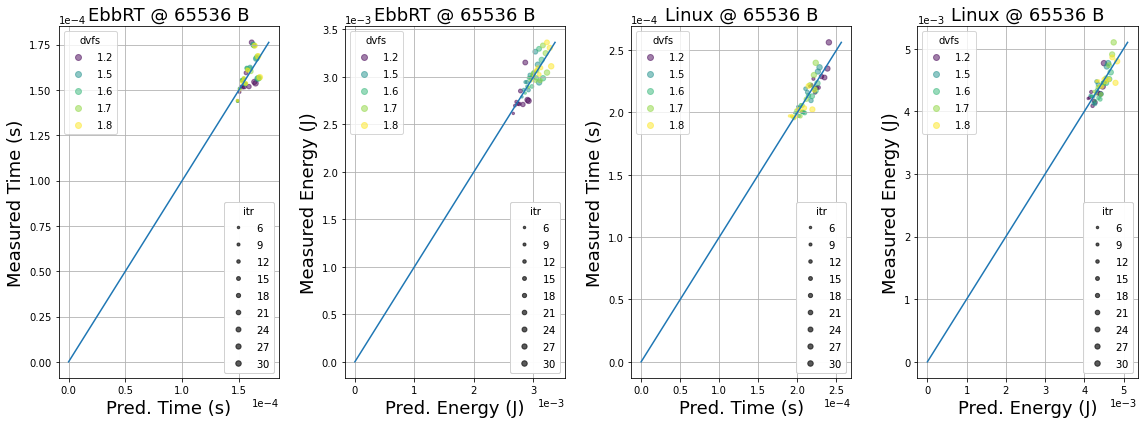

In [238]:
df_comb = pd.read_csv('/home/handong/jupyter/jupyter-notebooks/nic-tuning-experiments/bayesopt/summary_data/netpipe_combined.csv', sep=' ')
df_comb = df_comb[(df_comb['i'] == 1) & (df_comb['rapl'] == 135)]
#df_comb = df_comb[(df_comb['rapl'] == 135)]

df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: dvfs_dict[x])
df_comb = df_comb[(df_comb['itr']!=1) & (df_comb['dvfs']!=65535)] #filter out linux dynamic
df_comb = df_comb[(df_comb['dvfs'] < 1.9)]
df_comb = df_comb[(df_comb['dvfs'] != 1.3)]
#[ 6  8 10 12 14 16 20 24 28 30]
#[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
df_comb = df_comb[(df_comb['itr'] > 5) & (df_comb['itr'] < 31) & (df_comb['itr'] != 18) & (df_comb['itr'] != 22) & (df_comb['itr'] != 26)]
#df_comb = df_comb[(df_comb['dvfs'] == 1.3) | (df_comb['dvfs'] == 1.5)| (df_comb['dvfs'] == 1.7) | (df_comb['dvfs'] == 1.9) | (df_comb['dvfs'] == 2.1) | (df_comb['dvfs'] == 2.3) | (df_comb['dvfs'] == 2.5) | (df_comb['dvfs'] == 2.7) | (df_comb['dvfs'] == 2.9)]

#run(df_comb, n_iter=5000, lr=.1, rmsg=65536, mpred=['time', 'energy'], msys=['linux_tuned'])
plt.rcParams['figure.figsize'] = 16, 6
run(df_comb, n_iter=5000, lr=.1, rmsg=65536, mpred=['time', 'energy'], msys=['ebbrt_tuned', 'linux_tuned'])

[ 6  8 10 12 16 20 24 28]
SYS ebbrt_tuned
MSE_loss_time=2.400763157620155e-10 loss_time=15.4944 us max_time=-10.405628204345703 alpha=0.31501662731170654 gamma=0.09384206682443619 delta=0.6889466643333435 


<ipython-input-218-ecec3a150831>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-218-ecec3a150831>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:24: UserWarning: To copy cons

MSE_loss_time=5.66985625545491e-11 loss_time=7.52984 us max_time=-10.647892951965332 alpha=-0.054774001240730286 gamma=-0.043771304190158844 delta=0.6889466643333435 
MSE_loss_time=4.71281007279464e-11 loss_time=6.86499 us max_time=-10.705870628356934 alpha=-0.3536141812801361 gamma=-0.08803153038024902 delta=0.6889466643333435 
MSE_loss_time=4.294676161784141e-11 loss_time=6.55338 us max_time=-10.751740455627441 alpha=-0.548661470413208 gamma=-0.11911696940660477 delta=0.6889466643333435 
MSE_loss_time=4.140775609822422e-11 loss_time=6.43489 us max_time=-10.78447437286377 alpha=-0.6657953262329102 gamma=-0.13610464334487915 delta=0.6889466643333435 
MSE_loss_energy=9.304592907921847e-08 loss_energy=0.0003050343080363559J AA=20.347665786743164 BB=2.9713759422302246 CC=13.417655944824219 eta=3.0
MSE_loss_energy=2.5519205770692145e-08 loss_energy=0.00015974731850861267J AA=19.074033737182617 BB=2.66755747795105 CC=14.15481185913086 eta=1.5190255641937256
MSE_loss_energy=2.527484730656211

<ipython-input-218-ecec3a150831>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-218-ecec3a150831>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:24: UserWarning: To copy cons

MSE_loss_time=1.5295458416055712e-11 loss_time=3.91094 us max_time=-10.435206413269043 alpha=-0.22466744482517242 gamma=0.1316995620727539 delta=0.6601803302764893 
MSE_loss_time=1.481050121438907e-11 loss_time=3.84844 us max_time=-10.414266586303711 alpha=-0.1592252254486084 gamma=0.13410526514053345 delta=0.6601803302764893 
MSE_loss_time=1.4664510932807418e-11 loss_time=3.82943 us max_time=-10.4030122756958 alpha=-0.12323295325040817 gamma=0.1354716569185257 delta=0.6601803302764893 
MSE_loss_time=1.4620012476757754e-11 loss_time=3.82361 us max_time=-10.396893501281738 alpha=-0.10334795713424683 gamma=0.1362440437078476 delta=0.6601803302764893 
MSE_loss_energy=3.3536464718685247e-08 loss_energy=0.00018312963910488452J AA=20.879465103149414 BB=2.52333664894104 CC=13.815570831298828 eta=3.0
MSE_loss_energy=5.144879960429955e-09 loss_energy=7.172781859522813e-05J AA=19.566043853759766 BB=2.6061506271362305 CC=13.8846435546875 eta=2.2196929454803467
MSE_loss_energy=5.125097113530944e-0

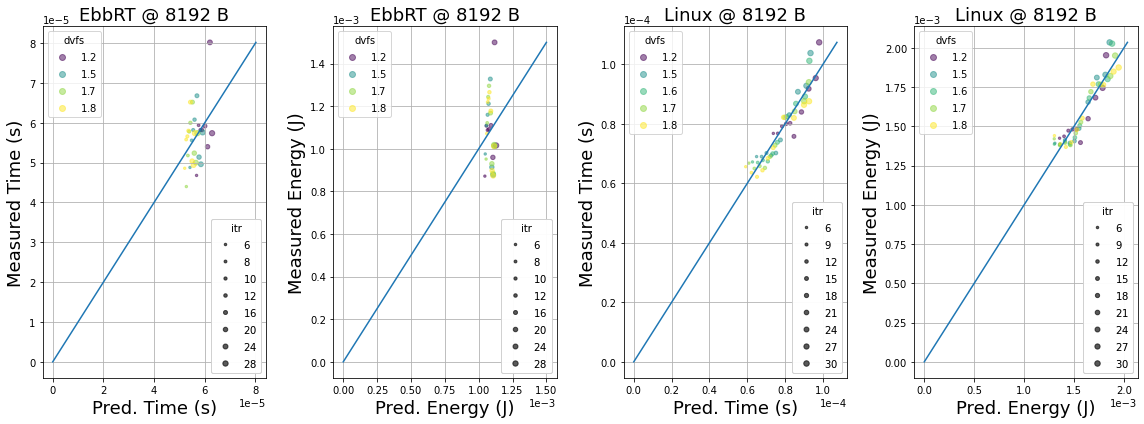

In [239]:
run(df_comb, n_iter=5000, lr=.1, rmsg=8192, mpred=['time', 'energy'], msys=['ebbrt_tuned', 'linux_tuned'])

[ 6  8 10 12 14 20 24 28 30 16]
SYS ebbrt_tuned
MSE_loss_time=5.402645578169643e-09 loss_time=73.50269 us max_time=-10.856658935546875 alpha=-0.845221996307373 gamma=0.02741457335650921 delta=0.6020134687423706 


<ipython-input-218-ecec3a150831>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-218-ecec3a150831>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:24: UserWarning: To copy cons

MSE_loss_time=2.7924372202524506e-11 loss_time=5.28435 us max_time=-9.80671215057373 alpha=-1.0148134231567383 gamma=0.010376421734690666 delta=0.6020134687423706 
MSE_loss_time=2.7908666347007417e-11 loss_time=5.28287 us max_time=-9.804288864135742 alpha=-1.0055655241012573 gamma=0.012113479897379875 delta=0.6020134687423706 
MSE_loss_time=2.7908633794285966e-11 loss_time=5.28286 us max_time=-9.804195404052734 alpha=-1.0051735639572144 gamma=0.012208165600895882 delta=0.6020134687423706 
MSE_loss_time=2.790863378907421e-11 loss_time=5.28286 us max_time=-9.804195404052734 alpha=-1.0051727294921875 gamma=0.012208874337375164 delta=0.6020134687423706 
MSE_loss_energy=1.0596956517583327e-06 loss_energy=0.0010294151989155458J AA=20.03651237487793 BB=2.660541296005249 CC=12.469120979309082 eta=3.0
MSE_loss_energy=3.14617344329506e-07 loss_energy=0.000560907607658789J AA=17.948144912719727 BB=6.6240129470825195 CC=12.44192123413086 eta=2.557882785797119
MSE_loss_energy=3.087394897188609e-07 

<ipython-input-218-ecec3a150831>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-218-ecec3a150831>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-218-ecec3a150831>:24: UserWarning: To copy cons

MSE_loss_time=3.7465522912855256e-12 loss_time=1.9356 us max_time=-9.50551700592041 alpha=-0.40142154693603516 gamma=0.20441022515296936 delta=0.6673144102096558 
MSE_loss_time=3.741934407245959e-12 loss_time=1.93441 us max_time=-9.505964279174805 alpha=-0.3948402404785156 gamma=0.20570772886276245 delta=0.6673144102096558 
MSE_loss_time=3.738652128992638e-12 loss_time=1.93356 us max_time=-9.506332397460938 alpha=-0.3892652690410614 gamma=0.20679178833961487 delta=0.6673144102096558 
MSE_loss_time=3.736328285193816e-12 loss_time=1.93296 us max_time=-9.506634712219238 alpha=-0.3845630884170532 gamma=0.20769570767879486 delta=0.6673144102096558 
MSE_loss_energy=5.13570804716215e-07 loss_energy=0.0007166385453743156J AA=20.80026626586914 BB=2.424548387527466 CC=13.849628448486328 eta=3.0
MSE_loss_energy=1.287722854045583e-08 loss_energy=0.00011347787687675439J AA=18.480554580688477 BB=8.813693046569824 CC=9.280960083007812 eta=2.8883984088897705
MSE_loss_energy=9.90294650912968e-09 loss_e

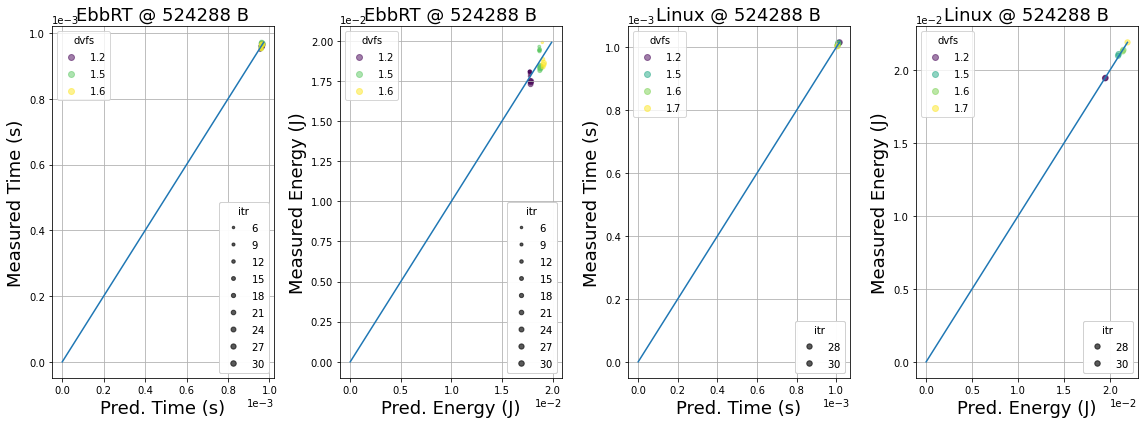

In [240]:
plt.rcParams['figure.figsize'] = 16, 6
run(df_comb, n_iter=5000, lr=.1, rmsg=524288, mpred=['time', 'energy'], msys=['ebbrt_tuned', 'linux_tuned'])

In [174]:
def inference_time(d, n_iter, lr, workload, sys, print_freq=10):    
    #starts randomly
    max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
    alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
    beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
    gamma = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
    delta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
    
    ninterrupts = d[:,4]
    energy = (d[:,0]/ninterrupts).log() ## joules/num_interrupts
    itr = d[:,1]
    dvfs = d[:,2]
    time = (d[:,3]/5000)
    msgsize = d[:,5]
        
    criterion = nn.MSELoss()
    optimizer_time = optim.Adam([max_time, alpha, gamma, delta], lr=lr)

    for i in range(n_iter):        
        t_busy = (torch.exp(max_time) / dvfs**(1+alpha)) ## dvfs impact on processing
        
        #pred_time = itr_suppress*itr + t_busy
        #pred_time = ((2*((itr*itr_suppress)**beta))/(10**6)) + (gamma*(2*((msgsize*8)/(10**10)))) + (2*t_busy)
        #pred_time = (gamma*itr*itr_suppress)*(dvfs**beta)
        #pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy)                
        
        #pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy) + (2*((msgsize*8)/(10**10)))
        beta = gamma*dvfs+delta
        pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy) + (2*((msgsize*8)/(10**10)))
        ## short circuting of ITR, i.e. slow-to-stay-busy effect, send ACK packets during processing
        
        #pred_time = A(itr)**beta*(dvfs**gamma)
        #pred_time = 2*itr**(alpha*dvfs)
        
        #import pdb
        #pdb.set_trace()
        
        #loss_time = criterion(pred_time/time, torch.ones((1,pred_time.shape[1])).double())
        loss_time = criterion(pred_time, time)
        
        if i % 1000 == 0:
            print(f'MSE_loss_time={loss_time.item()} loss_time={round(math.sqrt(loss_time.item())*10**6, 5)} us '
                 + f'max_time={max_time.item()} alpha={alpha.item()} gamma={gamma.item()} delta={delta.item()} ')
            
        optimizer_time.zero_grad()
        loss_time.backward()
        optimizer_time.step()


    return pred_time

In [175]:
def inference_energy(d, n_iter, lr, workload, sys, print_freq=10):
    #starts randomly
    #max_time = torch.tensor(torch.Tensor(1,1).uniform_(-5, 5), requires_grad=True)
    alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    gamma = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    delta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
    
    ninterrupts = d[:,4]
    energy = (d[:,0]/5000) #(d[:,0]/ninterrupts).log() ## joules/num_interrupts
    itr = d[:,1]
    dvfs = d[:,2]
    time = (d[:,3]/5000)
    msgsize = d[:,5]
        
    criterion = nn.MSELoss()
    optimizer_energy = optim.Adam([alpha, beta], lr=lr)
            
    for i in range(n_iter):
        #p_busy = (p_q*dvfs**(2+beta))
        #t_busy_energy = (max_time / dvfs**(1+beta))
        #t_q_energy = itr#(fixed_itr_suppress*itr)
        #t_q_energy = (interarrival_time - (fixed_itr_suppress*itr) - t_busy_energy)
        
        #pred_energy = (p_q * t_q_energy) + (p_busy * t_busy_energy)
        #pred_energy = AA*(fixed_itr_suppress*itr)**gamma + BB*dvfs**beta
        #loss_energy = criterion(pred_energy/energy, torch.ones((1,pred_energy.shape[1])).double())
        #pred_energy =  ((fixed_itr_suppress*itr*p_q)*((20*(10**6))/(fixed_itr_suppress*itr))) + (dvfs*beta)
        #pred_energy = ((alpha*(itr**gamma))*(delta*(dvfs**beta))) #+ (AA*(dvfs**beta))
        
        #pred_energy = (alpha*itr*((msgsize*8)/(10**10)))+(dvfs*beta)
        #pred_energy = alpha*(itr+dvfs)
        #pred_energy = alpha+np.log(itr)+np.log(dvfs)
        
        #pred_energy = (gamma*(fixed_itr_suppress*itr))*(dvfs**beta) #+ (AA*(dvfs**beta))        
        #pred_energy = 2*(gamma+(np.log(itr)))+(2*(beta*np.log(dvfs)))
        
        beta = gamma*dvfs+delta
        pred_time = ((2*(((itr**beta))))/(10**6)) + (2*t_busy) + (2*((msgsize*8)/(10**10)))
        
        loss_energy = criterion(pred_energy, energy)

        if i % 1000 == 0:
            print(f'MSE_loss_energy={loss_energy.item()} alpha={alpha.item()} beta={beta.item()}')
            
        optimizer_energy.zero_grad()
        loss_energy.backward(retain_graph=True)
        optimizer_energy.step()
    return pred_energy

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_time=6.105263736153823e-08 loss_time=247.08832 us max_time=-11.391225814819336 alpha=0.7308746576309204 gamma=0.3672170639038086 delta=0.6828203201293945 


<ipython-input-198-8f6bd0a245cb>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-198-8f6bd0a245cb>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-198-8f6bd0a245cb>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-198-8f6bd0a245cb>:24: UserWarning: To copy cons

MSE_loss_time=1.771637031682223e-10 loss_time=13.31029 us max_time=-9.615437507629395 alpha=-0.022785352542996407 gamma=0.13984856009483337 delta=0.6828203201293945 
MSE_loss_time=1.7714590118254352e-10 loss_time=13.30962 us max_time=-9.611628532409668 alpha=-0.01429019309580326 gamma=0.1401815116405487 delta=0.6828203201293945 
MSE_loss_time=1.7714589440242342e-10 loss_time=13.30962 us max_time=-9.611572265625 alpha=-0.01415804959833622 gamma=0.1401870846748352 delta=0.6828203201293945 
MSE_loss_time=1.7714589440238258e-10 loss_time=13.30962 us max_time=-9.611572265625 alpha=-0.014157860539853573 gamma=0.1401870995759964 delta=0.6828203201293945 
MSE_loss_time=1.7714589440238258e-10 loss_time=13.30962 us max_time=-9.611572265625 alpha=-0.014157860539853573 gamma=0.1401870995759964 delta=0.6828203201293945 
MSE_loss_time=1.7714589440238573e-10 loss_time=13.30962 us max_time=-9.611572265625 alpha=-0.014157861471176147 gamma=0.1401870995759964 delta=0.6828203201293945 
MSE_loss_time=1.77

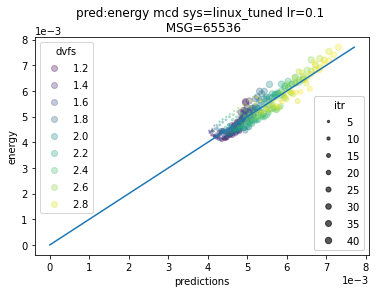

In [209]:
run(df_comb, n_iter=10000, lr=.1, rmsg=65536, mpred=['time', 'energy'], msys=['linux_tuned'])

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_time=1.46251835276159e-06 loss_time=1209.34625 us max_time=-11.885858535766602 alpha=0.07132470607757568 gamma=0.8096492290496826 delta=-0.11642897129058838 


<ipython-input-174-e7cfe7a98220>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-174-e7cfe7a98220>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-174-e7cfe7a98220>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-174-e7cfe7a98220>:6: UserWarning: To copy construc

MSE_loss_time=7.072609998480563e-10 loss_time=26.59438 us max_time=-9.570508003234863 alpha=-0.6329886317253113 gamma=0.177914097905159 delta=-0.7460958957672119 
MSE_loss_time=7.07224096347386e-10 loss_time=26.59369 us max_time=-9.570474624633789 alpha=-0.632748007774353 gamma=0.180347740650177 delta=-0.7442581057548523 
MSE_loss_time=7.071351205860702e-10 loss_time=26.59201 us max_time=-9.570417404174805 alpha=-0.6322575807571411 gamma=0.18532580137252808 delta=-0.7403994798660278 
MSE_loss_time=7.068707956200416e-10 loss_time=26.58704 us max_time=-9.570279121398926 alpha=-0.6310902833938599 gamma=0.19618730247020721 delta=-0.7316680550575256 
MSE_loss_time=7.054387198317444e-10 loss_time=26.5601 us max_time=-9.56977653503418 alpha=-0.6269953846931458 gamma=0.22700776159763336 delta=-0.7059494853019714 
MSE_loss_time=4.3142341745005496e-10 loss_time=20.77073 us max_time=-9.473012924194336 alpha=-0.21366718411445618 gamma=0.5000976324081421 delta=-0.3887026607990265 


KeyboardInterrupt: 

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_time=4.084167250518678e-09 loss_time=63.90749 us max_time=-11.584077835083008 alpha=0.680945634841919 gamma=-0.299230694770813 delta=-0.21227359771728516 


<ipython-input-198-8f6bd0a245cb>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-198-8f6bd0a245cb>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-198-8f6bd0a245cb>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-198-8f6bd0a245cb>:24: UserWarning: To copy cons

MSE_loss_time=3.311145496338428e-10 loss_time=18.19655 us max_time=-10.1016206741333 alpha=-0.7089433073997498 gamma=-0.06271976232528687 delta=-0.21227359771728516 
MSE_loss_time=2.3941358974396467e-10 loss_time=15.473 us max_time=-10.194531440734863 alpha=-0.5634053349494934 gamma=0.372245192527771 delta=-0.21227359771728516 
MSE_loss_time=2.064105298894164e-10 loss_time=14.36699 us max_time=-9.966798782348633 alpha=-0.13345687091350555 gamma=0.4011845588684082 delta=-0.21227359771728516 
MSE_loss_time=2.060588272502824e-10 loss_time=14.35475 us max_time=-9.944465637207031 alpha=-0.08817222714424133 gamma=0.40380439162254333 delta=-0.21227359771728516 
MSE_loss_time=2.060549843694182e-10 loss_time=14.35462 us max_time=-9.942144393920898 alpha=-0.08344041556119919 gamma=0.40407276153564453 delta=-0.21227359771728516 
MSE_loss_time=2.060549415605705e-10 loss_time=14.35461 us max_time=-9.941930770874023 alpha=-0.08298047631978989 gamma=0.4041007459163666 delta=-0.21227359771728516 
MSE_

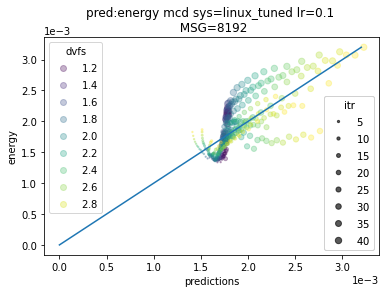

In [205]:
run(df_comb, n_iter=20000, lr=.1, rmsg=8192, mpred=['energy'], msys=['linux_tuned'])

[ 6  8 10 12 14 16 20 24 28 30]
SYS ebbrt_tuned
MSE_loss_time=5.307760841592641e-10 loss_time=23.03858 us max_time=-10.477350234985352 alpha=0.3237651586532593 gamma=-0.8744559288024902 delta=-0.7463735342025757 


<ipython-input-198-8f6bd0a245cb>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-198-8f6bd0a245cb>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-198-8f6bd0a245cb>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-198-8f6bd0a245cb>:24: UserWarning: To copy cons

MSE_loss_time=8.419945084611864e-11 loss_time=9.17603 us max_time=-10.413800239562988 alpha=-0.6822545528411865 gamma=-0.8796855211257935 delta=-0.7463735342025757 
MSE_loss_time=7.27466836252827e-11 loss_time=8.52917 us max_time=-10.541411399841309 alpha=-0.981916069984436 gamma=-0.8847626447677612 delta=-0.7463735342025757 
MSE_loss_time=7.106648381934523e-11 loss_time=8.43009 us max_time=-10.591769218444824 alpha=-1.0968222618103027 gamma=-0.8894336223602295 delta=-0.7463735342025757 
MSE_loss_time=7.079398064850203e-11 loss_time=8.41392 us max_time=-10.61220645904541 alpha=-1.1429905891418457 gamma=-0.8938983678817749 delta=-0.7463735342025757 
MSE_loss_time=7.074674451276259e-11 loss_time=8.41111 us max_time=-10.62060546875 alpha=-1.1618759632110596 gamma=-0.8982492089271545 delta=-0.7463735342025757 
MSE_loss_time=7.073716147837419e-11 loss_time=8.41054 us max_time=-10.624076843261719 alpha=-1.1696840524673462 gamma=-0.9025225639343262 delta=-0.7463735342025757 
MSE_loss_time=7.0

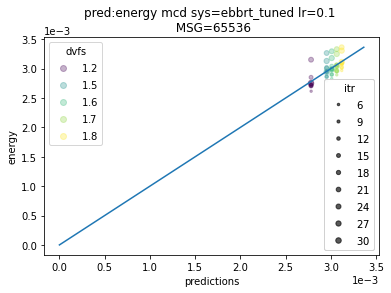

In [203]:
run(df_comb, n_iter=10000, lr=.1, rmsg=65536, mpred=['energy'], msys=['ebbrt_tuned'])

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_energy=10.401746502436177 alpha=0.26566147804260254 beta=1.5014312267303467


<ipython-input-143-ef625c4b722f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-143-ef625c4b722f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([340])) that is different to the input size (torch.Size([1, 340])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE_loss_energy=3.262613680156139e-07 alpha=-1.1357345581054688 beta=0.0009362245909869671
MSE_loss_energy=3.0685046480679154e-07 alpha=-0.9034810662269592 beta=0.0009217746555805206
MSE_loss_energy=2.754881005294182e-07 alpha=-0.5081182718276978 beta=0.0008971766801550984
MSE_loss_energy=2.3110499279456789e-07 alpha=0.10404948145151138 beta=0.0008590901270508766
MSE_loss_energy=1.7641721148758873e-07 alpha=0.9801543951034546 beta=0.0008045823778957129
MSE_loss_energy=1.2128311679971452e-07 alpha=2.108976125717163 beta=0.0007343515753746033
MSE_loss_energy=8.071682083613856e-08 alpha=3.3447418212890625 beta=0.0006574671133421361
MSE_loss_energy=6.308644321431112e-08 alpha=4.339838027954102 beta=0.0005955544183962047
MSE_loss_energy=6.190181196842276e-08 alpha=4.802731990814209 beta=0.0005897650262340903
yvalue torch.Size([340])


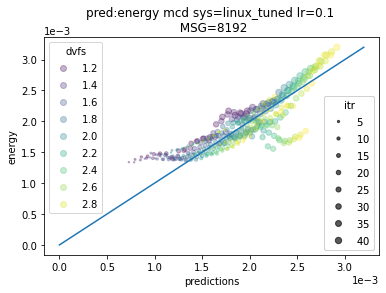

In [147]:
run(df_comb, n_iter=10000, lr=.1, rmsg=8192, mpred=['energy'], msys=['linux_tuned'])

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_time=1.0429160477799717e-09 loss_time=32.29421 us max_time=-10.445191383361816 alpha=-0.2974517345428467 gamma=0.13766062259674072 delta=0.7391911745071411 


<ipython-input-174-e7cfe7a98220>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-174-e7cfe7a98220>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-174-e7cfe7a98220>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-174-e7cfe7a98220>:6: UserWarning: To copy construc

MSE_loss_time=1.6557064500533677e-10 loss_time=12.86743 us max_time=-9.785359382629395 alpha=-0.21617451310157776 gamma=0.06116277351975441 delta=0.8767921328544617 
MSE_loss_time=1.6480417360827935e-10 loss_time=12.83761 us max_time=-9.745709419250488 alpha=-0.1549433320760727 gamma=0.07286328822374344 delta=0.8514975905418396 
MSE_loss_time=1.6478498169560058e-10 loss_time=12.83686 us max_time=-9.739546775817871 alpha=-0.14528939127922058 gamma=0.07468517124652863 delta=0.8475677371025085 
MSE_loss_time=1.647845454530269e-10 loss_time=12.83684 us max_time=-9.73862075805664 alpha=-0.143840029835701 gamma=0.0749572142958641 delta=0.8469799757003784 
MSE_loss_time=1.647845370474955e-10 loss_time=12.83684 us max_time=-9.73852825164795 alpha=-0.14368705451488495 gamma=0.07498495280742645 delta=0.8469218611717224 
MSE_loss_time=1.6478453680299063e-10 loss_time=12.83684 us max_time=-9.738523483276367 alpha=-0.14367903769016266 gamma=0.07498624920845032 delta=0.8469192385673523 
MSE_loss_tim

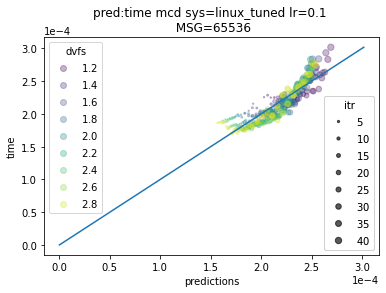

In [179]:
run(df_comb, n_iter=10000, lr=.1, rmsg=65536, mpred=['time'], msys=['linux_tuned'])


[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_energy=3.1736209974731158 alpha=1.6539652347564697 beta=-0.8273105621337891


<ipython-input-143-ef625c4b722f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-143-ef625c4b722f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([340])) that is different to the input size (torch.Size([1, 340])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE_loss_energy=8.609881749776227e-07 alpha=2.1432385444641113 beta=0.0013114969478920102
MSE_loss_energy=4.824321421179702e-07 alpha=1.61918044090271 beta=0.001572378329001367
MSE_loss_energy=3.5453072235186565e-07 alpha=1.2246168851852417 beta=0.0017687961226329207
MSE_loss_energy=3.4125223926614626e-07 alpha=1.071757197380066 beta=0.0018448913469910622
MSE_loss_energy=3.4100761104064225e-07 alpha=1.0487926006317139 beta=0.0018563230987638235
MSE_loss_energy=3.410073301453634e-07 alpha=1.047995924949646 beta=0.0018567200750112534
MSE_loss_energy=1.2136040151154726e-06 alpha=1.048421859741211 beta=0.002291131531819701
MSE_loss_energy=3.410102254985726e-07 alpha=1.0479880571365356 beta=0.001857515424489975
MSE_loss_energy=3.410073301154088e-07 alpha=1.047987937927246 beta=0.0018567241495475173
yvalue torch.Size([340])


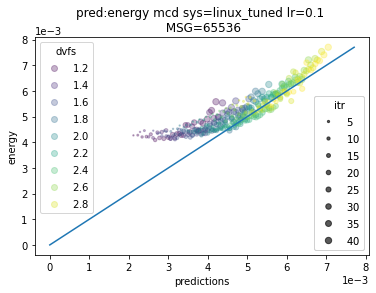

In [146]:
run(df_comb, n_iter=10000, lr=.1, rmsg=65536, mpred=['energy'], msys=['linux_tuned'])


[28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_energy=5.199010363610722 alpha=1.655785083770752 beta=-1.607767105102539


<ipython-input-143-ef625c4b722f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-143-ef625c4b722f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([1, 29])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE_loss_energy=3.3289138809710734e-05 alpha=2.7812421321868896 beta=-0.013115008361637592
MSE_loss_energy=1.4360415481617989e-05 alpha=1.9579185247421265 beta=-0.0049598123878240585
MSE_loss_energy=3.8635257924247674e-06 alpha=1.1497951745986938 beta=0.003044822718948126
MSE_loss_energy=1.4008444447896256e-06 alpha=0.6610794067382812 beta=0.00788565631955862
MSE_loss_energy=1.232328208547477e-06 alpha=0.5111297965049744 beta=0.009370938874781132
MSE_loss_energy=1.2306223463538695e-06 alpha=0.49479347467422485 beta=0.009532756172120571
MSE_loss_energy=1.2306216016418088e-06 alpha=0.4944464862346649 beta=0.009536191821098328
MSE_loss_energy=1.2306216417763603e-06 alpha=0.49444490671157837 beta=0.009536066092550755
MSE_loss_energy=1.2306610980935978e-06 alpha=0.49444931745529175 beta=0.009540589526295662
yvalue torch.Size([29])


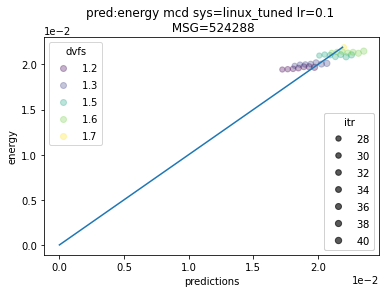

In [148]:
run(df_comb, n_iter=10000, lr=.1, rmsg=524288, mpred=['energy'], msys=['linux_tuned'])


[ 6  8 10 12 16 20 24 28]
SYS ebbrt_tuned
MSE_loss_time=9.3518833865048e-10 loss_time=30.58085 us max_time=-10.931262969970703 alpha=0.8639646768569946 gamma=-0.49780237674713135 delta=-0.21662914752960205


<ipython-input-68-4127e2a15255>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-68-4127e2a15255>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-68-4127e2a15255>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-68-4127e2a15255>:7: UserWarning: To copy construct f

MSE_loss_time=4.7445300777785e-11 loss_time=6.88805 us max_time=-10.515900611877441 alpha=-0.5818349123001099 gamma=-0.4936071038246155 delta=-0.2227908968925476
MSE_loss_time=4.236176593303981e-11 loss_time=6.50859 us max_time=-10.630703926086426 alpha=-0.748201847076416 gamma=-0.5089138746261597 delta=-0.23197980225086212
MSE_loss_time=4.217741654004542e-11 loss_time=6.49441 us max_time=-10.652167320251465 alpha=-0.7784810662269592 gamma=-0.5206874012947083 delta=-0.2379435896873474
MSE_loss_time=4.21571846459416e-11 loss_time=6.49286 us max_time=-10.65610408782959 alpha=-0.7841393947601318 gamma=-0.531475305557251 delta=-0.24318993091583252
MSE_loss_time=4.2143893041436884e-11 loss_time=6.49183 us max_time=-10.656660079956055 alpha=-0.7850796580314636 gamma=-0.5417852997779846 delta=-0.2481829822063446
MSE_loss_time=4.2131668979084197e-11 loss_time=6.49089 us max_time=-10.656660079956055 alpha=-0.7851954102516174 gamma=-0.5517299771308899 delta=-0.25301480293273926
MSE_loss_time=4.2

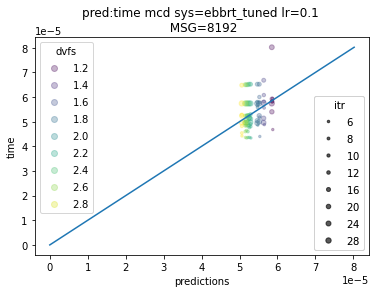

In [155]:
run(df_comb, n_iter=10000, lr=.1, rmsg=8192, mpred=['time'], msys=['ebbrt_tuned'])

[ 6  8 10 12 14 16 20 24 28 30]
SYS ebbrt_tuned
MSE_loss_energy=1.8716230579680093 alpha=-0.8316636085510254 beta=0.874535083770752


<ipython-input-143-ef625c4b722f>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-143-ef625c4b722f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([49])) that is different to the input size (torch.Size([1, 49])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE_loss_energy=6.246585413241833e-07 alpha=-1.3500171899795532 beta=0.0026435942854732275
MSE_loss_energy=2.92997325904283e-07 alpha=-0.7278295755386353 beta=0.002298724604770541
MSE_loss_energy=1.1255511871187007e-07 alpha=-0.123292937874794 beta=0.001963638933375478
MSE_loss_energy=7.152672242858627e-08 alpha=0.2361350953578949 beta=0.001764413551427424
MSE_loss_energy=6.885477372127496e-08 alpha=0.34346234798431396 beta=0.0017049235757440329
MSE_loss_energy=6.88297931080648e-08 alpha=0.35467055439949036 beta=0.0016987109556794167
MSE_loss_energy=6.882978363556487e-08 alpha=0.3548932373523712 beta=0.001698593609035015
MSE_loss_energy=4.516908398239483e-07 alpha=0.35528793931007385 beta=0.0020928415469825268
MSE_loss_energy=6.883143400136191e-08 alpha=0.35489335656166077 beta=0.0016977684572339058
MSE_loss_energy=6.882978354508891e-08 alpha=0.3548942506313324 beta=0.001698586973361671
MSE_loss_energy=3.676757241138263e-05 alpha=0.35874953866004944 beta=0.005558536853641272
MSE_loss_e

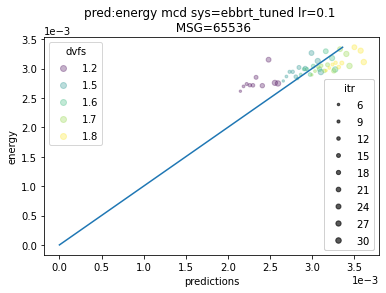

In [159]:
run(df_comb, n_iter=15000, lr=.1, rmsg=65536, mpred=['energy'], msys=['ebbrt_tuned'])

[ 6  8 10 12 14 16 20 24 28 30]
SYS ebbrt_tuned
MSE_loss_time=6.258170179356339e-10 loss_time=25.01634 us max_time=-11.112141609191895 alpha=-0.20667457580566406 gamma=0.20616579055786133 delta=0.14654159545898438


<ipython-input-68-4127e2a15255>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-68-4127e2a15255>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-68-4127e2a15255>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-68-4127e2a15255>:7: UserWarning: To copy construct f

MSE_loss_time=3.8352846966180634e-11 loss_time=6.19297 us max_time=-10.703995704650879 alpha=-0.4967239797115326 gamma=0.32468709349632263 delta=0.23750276863574982
MSE_loss_time=3.739892863921175e-11 loss_time=6.11547 us max_time=-10.730485916137695 alpha=-0.5888569355010986 gamma=0.3261134624481201 delta=0.22593876719474792
MSE_loss_time=3.6967499875839745e-11 loss_time=6.08009 us max_time=-10.750848770141602 alpha=-0.6498305797576904 gamma=0.3184581995010376 delta=0.23383992910385132
MSE_loss_time=3.6707352629978575e-11 loss_time=6.05866 us max_time=-10.767232894897461 alpha=-0.6932665705680847 gamma=0.3067343533039093 delta=0.25083649158477783
MSE_loss_time=3.651504617565465e-11 loss_time=6.04277 us max_time=-10.781044006347656 alpha=-0.7266898155212402 gamma=0.29346156120300293 delta=0.2716030478477478
MSE_loss_time=3.63587941477605e-11 loss_time=6.02983 us max_time=-10.793082237243652 alpha=-0.7542036175727844 gamma=0.2799374759197235 delta=0.2933439016342163
MSE_loss_time=3.6227

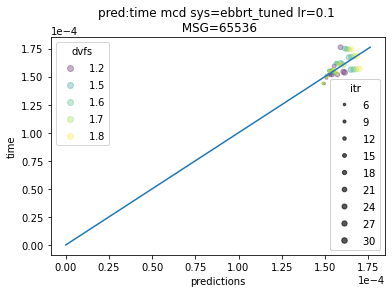

In [154]:
run(df_comb, n_iter=10000, lr=.1, rmsg=65536, mpred=['time'], msys=['ebbrt_tuned'])

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_energy=18.681472224736677 alpha=-0.0990293025970459 J


<ipython-input-30-0addb9a7217e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
<ipython-input-30-0addb9a7217e>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-2, 2), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([680])) that is different to the input size (torch.Size([1, 680])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE_loss_energy=3.349001683366263e-07 alpha=5.4724056099075824e-05 J
MSE_loss_energy=3.3489944894610644e-07 alpha=5.466543007059954e-05 J
MSE_loss_energy=3.3489944894458e-07 alpha=5.466537913889624e-05 J
MSE_loss_energy=3.3489944894409114e-07 alpha=5.4665350035065785e-05 J
MSE_loss_energy=3.34899448943987e-07 alpha=5.466534275910817e-05 J
MSE_loss_energy=3.348994489439332e-07 alpha=5.466533184517175e-05 J
MSE_loss_energy=3.3489944894389087e-07 alpha=5.466532820719294e-05 J
MSE_loss_energy=1.0592082571550955e-06 alpha=2.1330277377273887e-05 J
MSE_loss_energy=3.440480151089373e-07 alpha=5.838388460688293e-05 J
MSE_loss_energy=3.349623944952624e-07 alpha=5.497341408045031e-05 J
MSE_loss_energy=7.164122409006158e-07 alpha=3.072250183322467e-05 J
MSE_loss_energy=4.36903829727795e-06 alpha=-2.3160711862146854e-05 J
MSE_loss_energy=3.348995113745342e-07 alpha=5.4675008868798614e-05 J
MSE_loss_energy=3.3489944900058766e-07 alpha=5.466504080686718e-05 J
MSE_loss_energy=3.349039223646735e-07 alp

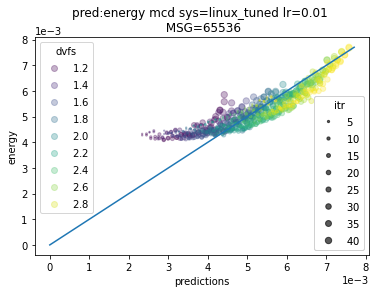

In [45]:
run_energy(df_comb, n_iter=30000, lr=.01, rmsg=65536, mpred=['energy'], msys=['linux_tuned'])


[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40]
SYS linux_tuned
MSE_loss_time=2.607992334315835e-09 loss_time=51.06851 us


<ipython-input-57-930966d77645>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-57-930966d77645>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-57-930966d77645>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
/home/handong/anaconda3/lib/python3.8/site-packages/torch/nn/modu

MSE_loss_time=1.4321045374656487e-10 loss_time=11.96706 us
MSE_loss_time=1.1229138646877116e-10 loss_time=10.59676 us
MSE_loss_time=9.833010400099115e-11 loss_time=9.91615 us
MSE_loss_time=9.200676189518122e-11 loss_time=9.59202 us
MSE_loss_time=8.793716094145902e-11 loss_time=9.37748 us
MSE_loss_time=8.473511251011704e-11 loss_time=9.20517 us
MSE_loss_time=8.21104176869666e-11 loss_time=9.06148 us
MSE_loss_time=7.996481491071716e-11 loss_time=8.9423 us
MSE_loss_time=7.822415766882217e-11 loss_time=8.84444 us
MSE_loss_time=7.682671397251105e-11 loss_time=8.76508 us
MSE_loss_time=7.571198302318803e-11 loss_time=8.70126 us
MSE_loss_time=7.48307368101092e-11 loss_time=8.65048 us
MSE_loss_time=7.413629515511132e-11 loss_time=8.61024 us
MSE_loss_time=7.359265064749525e-11 loss_time=8.57862 us
MSE_loss_time=7.316875728823207e-11 loss_time=8.55387 us
MSE_loss_time=7.283833685100317e-11 loss_time=8.53454 us
MSE_loss_time=7.258367014843486e-11 loss_time=8.51961 us
MSE_loss_time=7.23863011322811

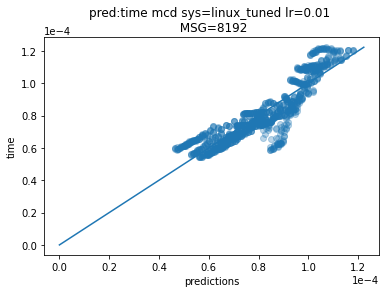

In [65]:
df_comb = pd.read_csv('/home/handong/jupyter/jupyter-notebooks/nic-tuning-experiments/bayesopt/summary_data/netpipe_combined.csv', sep=' ')
#df_comb = df_comb[(df_comb['i'] == 1) & (df_comb['rapl'] == 135)]
df_comb = df_comb[(df_comb['rapl'] == 135)]

df_comb['dvfs'] = df_comb['dvfs'].apply(lambda x: dvfs_dict[x])
df_comb = df_comb[(df_comb['itr']!=1) & (df_comb['dvfs']!=65535)] #filter out linux dynamic

run_energy(df_comb, n_iter=30000, lr=.01, rmsg=8192, mpred=['time'], msys=['linux_tuned'])

[ 6  8 10 12 14 16 20 24 28 30]
SYS ebbrt_tuned
loss_time=2.57520754163816e-06 max_time=-11.216626167297363 alpha=0.3909003734588623 gamma=0.9856512546539307 delta=0.5502802133560181


<ipython-input-14-718e03a868a5>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-14-718e03a868a5>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-14-718e03a868a5>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-14-718e03a868a5>:24: UserWarning: To copy construc

loss_time=4.969348230600252e-10 max_time=-11.678744316101074 alpha=0.705072283744812 gamma=0.5869538187980652 delta=0.15162181854248047
loss_time=3.1589909805032055e-10 max_time=-11.555351257324219 alpha=0.6717889904975891 gamma=0.5569562315940857 delta=0.1252904087305069
loss_time=2.596477904439758e-10 max_time=-11.356971740722656 alpha=0.6064764261245728 gamma=0.545141339302063 delta=0.11924216151237488
loss_time=1.9554310192149585e-10 max_time=-11.130919456481934 alpha=0.5296098589897156 gamma=0.5335561037063599 delta=0.11535559594631195
loss_time=1.3196472427766278e-10 max_time=-10.906689643859863 alpha=0.4496612846851349 gamma=0.5181466341018677 delta=0.10872402787208557
loss_time=8.627199477662976e-11 max_time=-10.721221923828125 alpha=0.37631598114967346 gamma=0.5000279545783997 delta=0.09867574274539948
loss_time=6.440469141453763e-11 max_time=-10.59963607788086 alpha=0.31640923023223877 gamma=0.483280211687088 delta=0.08744902908802032
loss_time=5.6820670550361005e-11 max_time

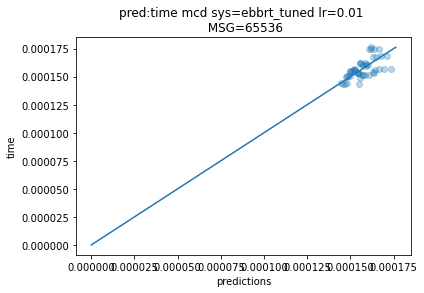

In [32]:
run_energy(df_comb, n_iter=20000, lr=0.01, rmsg=65536, mpred=['time'], msys=['ebbrt_tuned'])

[ 6  8 10 12 14 18 20 22 24 26 28 30 32 34 36 38 40 16]
SYS ebbrt_tuned
loss_time=1.3230961388258921e-08 max_time=-11.893648147583008 alpha=0.6270890235900879 gamma=0.18047595024108887 delta=-0.09962725639343262


<ipython-input-14-718e03a868a5>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_time = torch.tensor(torch.Tensor(1,1).uniform_(-12, -10), requires_grad=True)
<ipython-input-14-718e03a868a5>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-14-718e03a868a5>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(torch.Tensor(1,1).uniform_(-1, 1), requires_grad=True)
<ipython-input-14-718e03a868a5>:24: UserWarning: To copy construc

loss_time=1.8958488275455196e-09 max_time=-11.03542423248291 alpha=0.3844453692436218 gamma=0.24624042212963104 delta=0.8157742619514465
loss_time=4.0103061025381426e-10 max_time=-9.965204238891602 alpha=0.015366299077868462 gamma=0.09874476492404938 delta=0.8807123303413391
loss_time=1.2521801763705126e-10 max_time=-9.682907104492188 alpha=-0.24912947416305542 gamma=0.09442934393882751 delta=0.7038712501525879
loss_time=8.856843543575778e-11 max_time=-9.702617645263672 alpha=-0.4068114459514618 gamma=0.1354701966047287 delta=0.6141543984413147
loss_time=6.996599469468223e-11 max_time=-9.724239349365234 alpha=-0.5223428010940552 gamma=0.16338804364204407 delta=0.55540931224823
loss_time=6.025628725733556e-11 max_time=-9.740906715393066 alpha=-0.6078701615333557 gamma=0.18102142214775085 delta=0.5154772996902466
loss_time=5.5122739095906116e-11 max_time=-9.75363540649414 alpha=-0.6712750792503357 gamma=0.19214054942131042 delta=0.4882328510284424
loss_time=5.2386910228608144e-11 max_tim

/home/handong/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


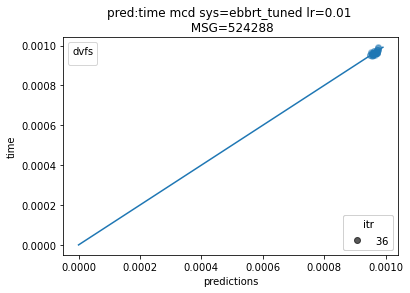

In [30]:
run_energy(df_comb, n_iter=10000, lr=0.01, rmsg=524288, mpred=['time'], msys=['ebbrt_tuned'])